In [1]:
!pip install librosa
!pip install pretty_midi

In [2]:
import librosa, librosa.display

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from sheet_music_model import *

from torch.nn import Transformer
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss
import torch

%load_ext autoreload
%autoreload 2

In [3]:
def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

def generate_sine(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

C:\Users\yuanx\AppData\Local\Temp/ipykernel_62776/3547333271.py:12: FutureWarning: Pass y=[ 0.         -0.00353769 -0.00547527 ...  0.00227958  0.00225402
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_boundaries = librosa.onset.onset_detect(


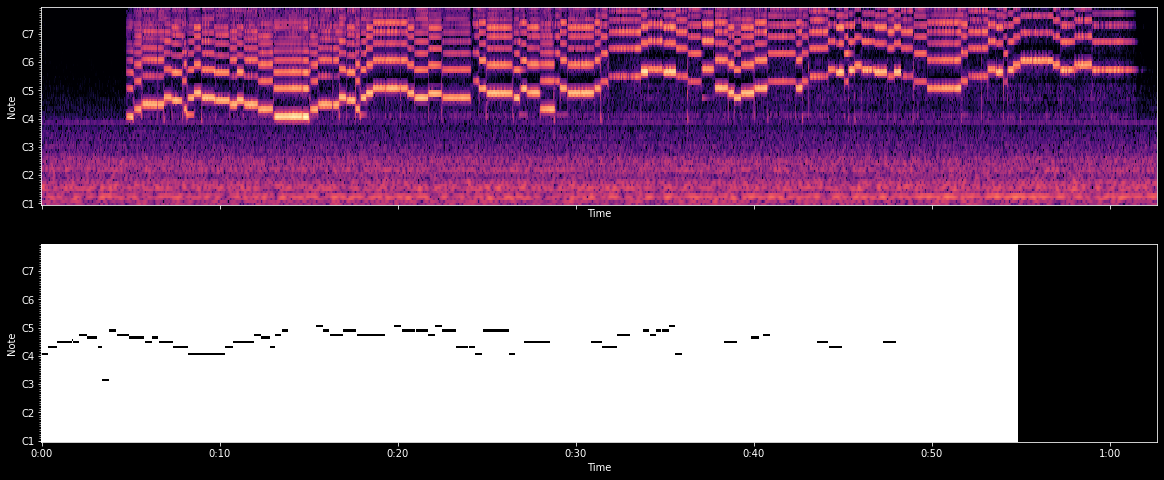

In [15]:
# Librosa method of generating sheet music
filename = "data/01_Jupiter_vn_vc/AuSep_1_vn_01_Jupiter.wav"
audio, rate = librosa.load("../../" + filename, mono = True)

audio = np.hstack([[0], audio])

C = np.abs(librosa.cqt(audio))

fig, ax = plt.subplots(2, 1, figsize = (20, 8), sharex = True)
librosa.display.specshow(librosa.amplitude_to_db(C, ref = np.max), ax = ax[0], sr=rate, x_axis='time', y_axis='cqt_note')

onset_boundaries = librosa.onset.onset_detect(
    audio,
    sr=rate, units='samples', 
    backtrack = False,
)

y = np.concatenate([
    estimate_pitch_and_generate_sine(audio, onset_boundaries, i, sr=rate)
    for i in range(len(onset_boundaries)-1)
])

actlProb_threshold = 0.5
C = np.abs(librosa.cqt(y))
C = (C - C.min()) / (C.max() - C.min())
C = np.apply_along_axis(lambda x: ((x == x.max()) & (x > actlProb_threshold)), axis=1, arr=C.T)
librosa.display.specshow(C.T, ax = ax[1], sr=rate, x_axis='time', y_axis='cqt_note')

In [16]:
C.shape

(2361, 84)

In [17]:
ipd.Audio(y, rate = rate)

c:\Users\yuanx\Documents\GitHub\music-decomp\AI\Sheet Music\sheet_music_model.py:31: FutureWarning: Pass y=[0.00000000e+00 1.56918191e-02 3.12868930e-02 ... 1.08128163e-01
 5.63465114e-02 1.04059610e-13], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  midi = pm.PrettyMIDI(initial_tempo=librosa.beat.tempo(song, rate).mean())
c:\Users\yuanx\Documents\GitHub\music-decomp\AI\Sheet Music\sheet_music_model.py:13: FutureWarning: Pass y=[0.00000000e+00 1.56918191e-02 3.12868930e-02 ... 1.08128163e-01
 5.63465114e-02 1.04059610e-13], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chroma = librosa.feature.chroma_cqt(song, rate).sum(1)
c:\Users\yuanx\Documents\GitHub\music-decomp\AI\Sheet Music\sheet_music_model.py:43: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  intervals, frameLenSecs = {}, li

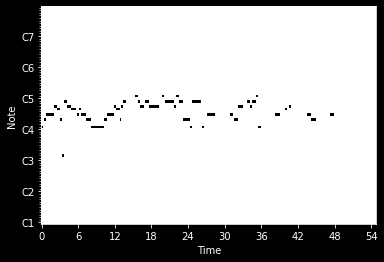

In [18]:
midi = createMIDI(song = y, rate = rate, instrument = "Violin", actlProb = C, actlProb_threshold = 0.9)
librosa.display.specshow(C.T, sr=rate, x_axis='time', y_axis='cqt_note')

In [20]:
midi.write("./testing.mid")